In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

trancuate_t = 96 # set this parameter to control at which time step you stop using the signal
grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

Set Parameters

In [2]:
batch_size=64
num_convs = 10
Non_Residual = False # note that some of the networks had been trained as non-residual)

#### Model import correct model
from Naive_CNN_3D import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

AF = 3 #                # defined so far for noisy:3, 5, 10, 20, 40

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/Layer/model.pth"  # Replace with your file path
#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_possoin_r0/5Layer/model.pth"
#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Alternating/5Layer/model.pth"
#saved_model_path = "../saved_models/Naive_CNN_3D_Non_Residual_AF_5_possoin_r0/5Layer/model.pth"
saved_model_path = f"../saved_models/Naive_CNN_3D_AF_{AF}_possoin_r0_Full2Low_SC/{num_convs}Layer/model.pth"

#### Load data ####
Ground_Truth = np.load('../data/Low_Rank_8_P03-P08_masked.npy')

Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_Low_Rank/Undersampled_possoin_3D_fixed_r0_AF_{AF}_Single_Combination.npy')

#Undersampled_Data = np.load('../data/Undersampled_Data/combined_undersampled_possoin_3D_fixed_r0_AF_5.npy')
#Undersampled_Data = np.load('../data/Undersampled_Data/combined_undersampled_Alternating_AF_3.npy')
#Undersampled_Data = np.load('../data/Undersampled_Data/combined_undersampled_possoin_3D_fixed_r0_AF_3.npy') ## Data set with accerleration factor 3

In [3]:
#### Train_Test_Split ####
ground_truth_train, ground_truth_test = Ground_Truth[:,:,:,:,:,:5], Ground_Truth[:,:,:,:,:,5]  # Method: Leave last MRSI measurement as test set

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:,:,:,:,:5], Undersampled_Data[:,:,:,:,:,5]

#### Fourier transform ####
training_undersampled, test_undersampled = fourier_transform(NN_input_train), fourier_transform(NN_input_test)

#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(22, 22, 21, -1), ground_truth_test.reshape(22, 22, 21, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(22, 22, 21, -1), NN_input_test.reshape(22, 22, 21, -1)
training_undersampled, test_undersampled = training_undersampled.reshape(22, 22, 21, -1), test_undersampled.reshape(22, 22, 21, -1)

#### Normalize data #####
normalized_input_train, normalized_ground_truth_train, norm_values_train = normalize_data_per_image_new(NN_input_train, ground_truth_train)
normalized_input_test, normalized_ground_truth_test, norm_values_test = normalize_data_per_image_new(NN_input_test, ground_truth_test)
_, normalized_train_FT, _ = normalize_data_per_image_new(NN_input_train, training_undersampled)
_, normalized_test_FT, _ = normalize_data_per_image_new(NN_input_test, test_undersampled)

#### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch(normalized_input_train, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_train, grouped_time_steps)
test_data, test_labels = reshape_for_pytorch(normalized_input_test, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_test, grouped_time_steps)

# Prepare k-space data (reshape undersampled k-space as well)
train_k_space = reshape_for_pytorch(normalized_train_FT, grouped_time_steps)
test_k_space = reshape_for_pytorch(normalized_test_FT, grouped_time_steps)

In [4]:
#### Set parameters ####

# Create TensorDataset instances
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Number of convolutional layers
model = Naive_CNN_3D(grouped_time_steps=grouped_time_steps, num_convs=num_convs).to(device)

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/5Layer/model.pth"  # Replace with your file path

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

Undersampling error / noise error: 0.749542


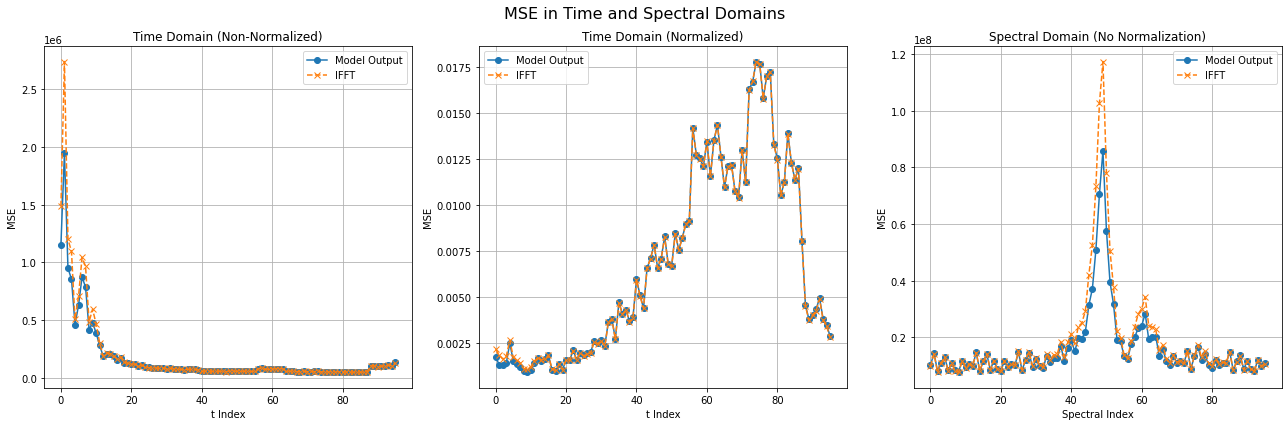

==== Model Output vs Ground Truth ====
Total MSE in image domain: 83996.26041666667
Normalized Total MSE in image domain: 0.003385196568688079
Total MSE in spectral domain: 8063640.776124336

==== Model Input vs Ground Truth ====
Total MSE in image domain: 96311.11458333333
Normalized Total MSE in image domain: 0.0033931209380658306
Total MSE in spectral domain: 9245867.987344703


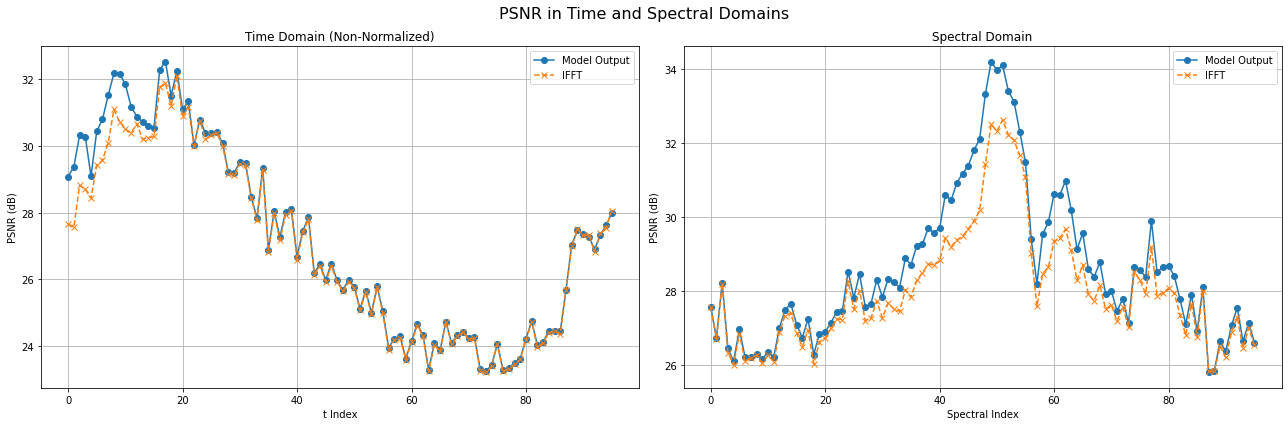

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    27.21185302734375
Average PSNR in frequency domain: 28.5834206193574

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    26.984094619750977
Average PSNR in frequency domain: 28.00816949188395


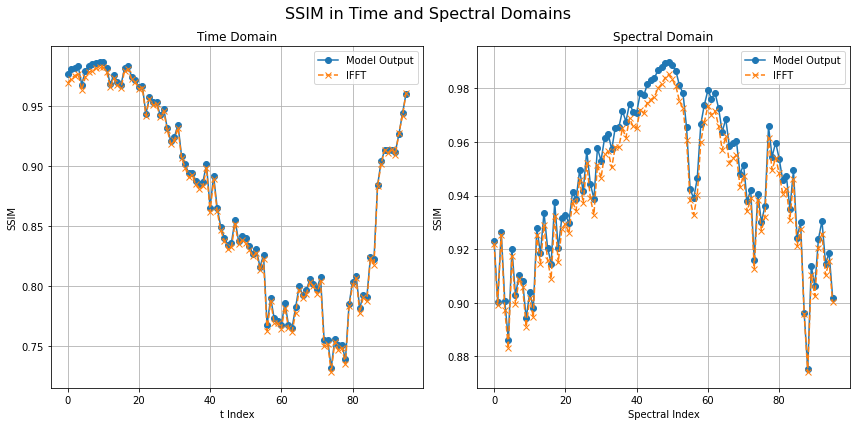

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.8751213242130964
Average SSIM in frequency domain: 0.9450345956631478

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.8721653893941866
Average SSIM in frequency domain: 0.9403738905680341


In [5]:
Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,5]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D

model_input = Undersampled_Data[:,:,:,:,:,5]

if Non_Residual:
    Model_Outputs_Test_Set = Model_Outputs_Test_Set - model_input

Noise = ground_truth[:, :, :, 95, :]   # e.g. shape: (X, Y, Z, coil_dim)

# Compute 2-norm per coil
two_norm_per_big_T = np.sqrt(np.sum(np.abs(Noise)**2, axis=(0, 1, 2)))
# shape of two_norm_per_coil is now (coil_dim,)

# Take the mean across coils
two_norm_noise_average = np.mean(two_norm_per_big_T)

Undersampling_Error = ground_truth[:, :, :, 0, :] - model_input[:, :, :, 0, :]  # e.g. shape: (X, Y, Z, coil_dim)

# Compute 2-norm per coil
two_norm_per_big_T = np.sqrt(np.sum(np.abs(Undersampling_Error)**2, axis=(0, 1, 2)))
# shape of two_norm_per_coil is now (coil_dim,)

# Take the mean across coils
two_norm_US_average = np.mean(two_norm_per_big_T)

Quotient = two_norm_US_average / two_norm_noise_average

print("Undersampling error / noise error:", Quotient)

norm_values_test = norm_values_test.reshape(96,8)
model_input = Undersampled_Data[:,:,:,:,:,5]

plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test,  label = "Model Output")

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:278: RuntimeWarning: invalid value encountered in float_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


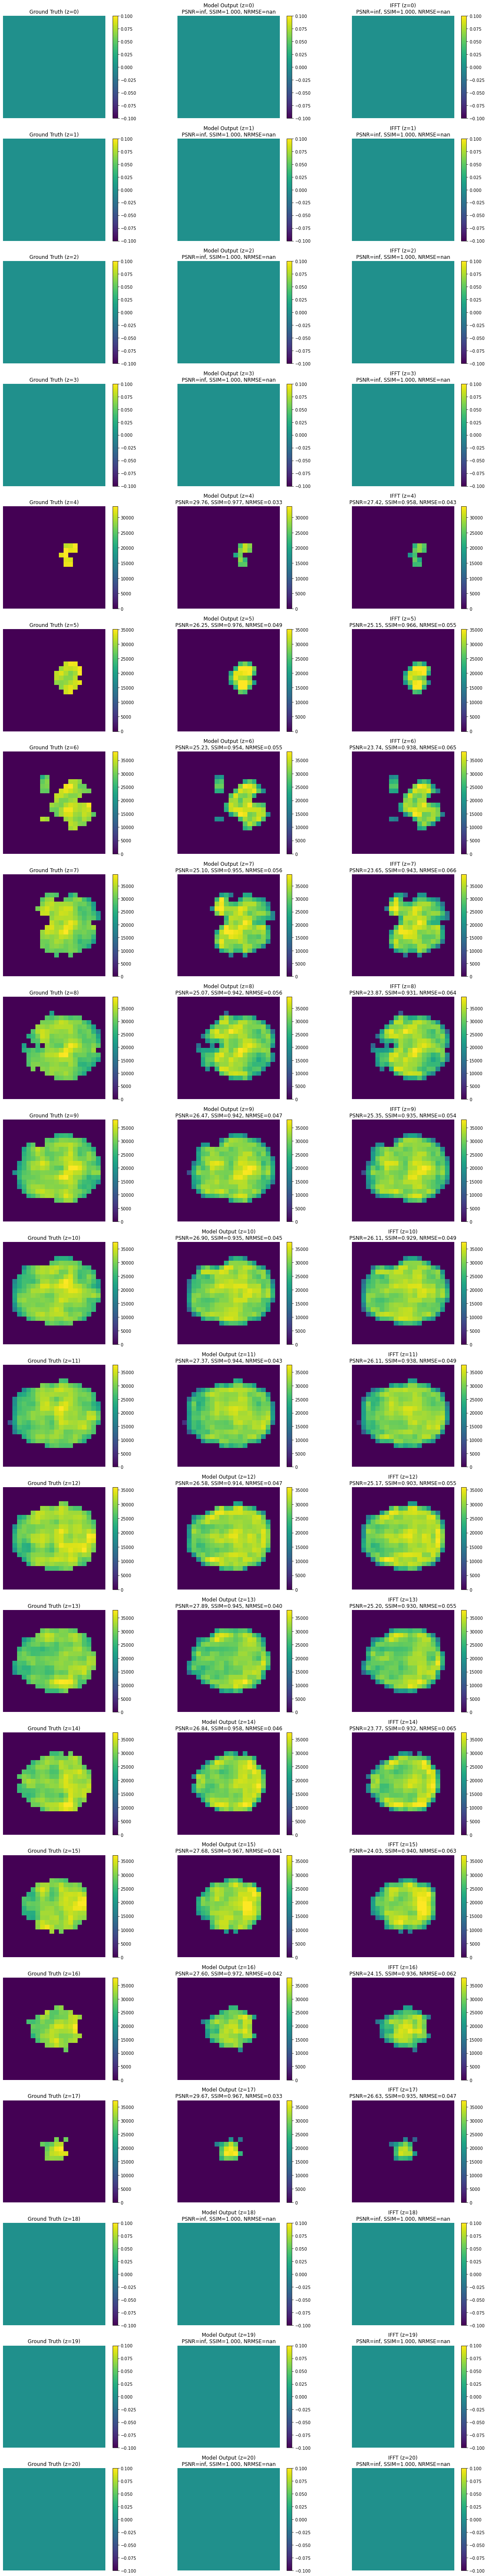

In [6]:
t = 1
T = 7

model_input = Undersampled_Data[:,:,:,:,:,5]

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, t, T, domain="time")

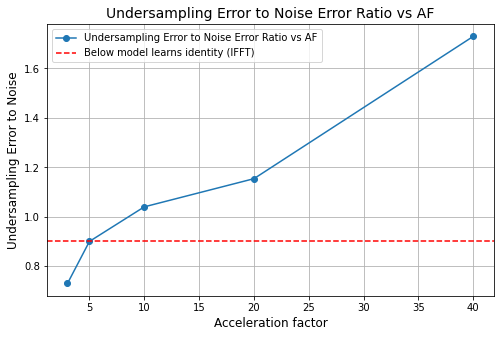

In [7]:
#### Note that the Ratio is computed in the statistics cell

AF = [3,5,10,20,40]
Ratio = [0.73, 0.9, 1.04, 1.154, 1.73]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(AF, Ratio, marker='o', linestyle='-', label='Undersampling Error to Noise Error Ratio vs AF')

plt.axhline(y=0.9, color='r', linestyle='--', label='Below model learns identity (IFFT)')

# Labels and title
plt.xlabel('Acceleration factor', fontsize=12)
plt.ylabel('Undersampling Error to Noise', fontsize=12)
plt.title('Undersampling Error to Noise Error Ratio vs AF', fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


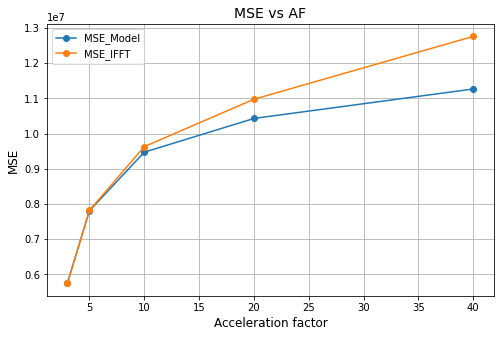

In [8]:
# Here I plot MSE in image domain vs AF

AF = [3,5,10,20,40]
MSE_Model = [5767337, 7808766, 9472584, 10431753, 11269272]
MSE_IFFT = [5742150, 7819783, 9631808, 10977836, 12765058]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(AF, MSE_Model, marker='o', linestyle='-', label='MSE_Model')

plt.plot(AF, MSE_IFFT, marker='o', linestyle='-', label='MSE_IFFT')

#plt.axvline(y=0.9, color='r', linestyle='--', label='Below model learns identity (IFFT)')

# Labels and title
plt.xlabel('Acceleration factor', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs AF', fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()